In [ ]:
import logging

import os
from pathlib import Path
from io import StringIO
import pickle

from pathlib import Path
from io import StringIO
import pickle

import numpy as np

In [3]:
logging.basicConfig(level=logging.DEBUG)

class WordsEmbeddings(object):

    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):

    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):

    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

DEBUG:__main__:converting and loading words embeddings from text file glove.twitter.27B.50d.txt
DEBUG:__main__:words embeddings loaded


[[ 5.8579e-01  8.0163e-02  1.9010e-01 -4.2974e-01 -6.7700e-01 -7.4183e-01
   2.3548e-01  5.6125e-01  3.4123e-02  6.6093e-01 -6.5666e-01 -3.1038e-01
  -3.3108e+00 -7.2266e-01 -1.8421e+00  9.9063e-01  2.6346e-02 -3.5894e-01
  -3.6259e-01  3.3939e-01  3.6955e-01  1.4748e-01 -4.5263e-01  3.8507e-01
  -5.6107e-01 -4.6079e-01  4.5029e-01 -4.5864e-02  8.2711e-01 -1.8816e-03
   4.5242e-01  6.7928e-01  7.2897e-01  6.7967e-02  3.0747e-01 -3.0777e-02
   1.4615e-01  9.8352e-01  3.0713e-01 -4.0797e-01 -1.6674e+00 -4.8884e-01
  -3.7614e-01  1.1126e+00 -8.0011e-01  2.9470e-01  2.1728e-01 -6.8735e-01
  -2.8111e-01  1.3931e-01]
 [ 2.8751e-01  3.1323e-01 -2.9318e-01  1.7199e-01 -6.9232e-01 -4.5930e-01
   1.3364e+00  7.0900e-01  1.2118e-01  1.1476e-01 -4.8505e-01 -8.8608e-02
  -3.0154e+00 -5.4024e-01 -1.3260e+00  3.9477e-01  1.1755e-01 -1.7816e-01
  -3.2272e-01  2.1715e-01  4.3144e-02 -4.3666e-01 -5.5857e-01 -4.7601e-01
  -9.5172e-02  3.1934e-03  1.1920e-01 -2.3643e-01  1.3234e+00 -4.5093e-01
  -6.5837e-

DEBUG:__main__:loading words embeddings from pickle gloveembedding.pkl
DEBUG:__main__:words embeddings loaded
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000000B499480CC8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000000B499480CC8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


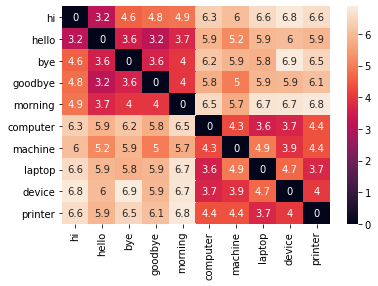

In [19]:
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt

def main():
    #model = FasttextEmbeddings()
    model = GloveEmbeddings()
    #print(model.get_words_embeddings(['hi', 'hello', 'bye', 'goodbye', 'morning', 'computer', 'machine', 'laptop', 'device', 'printer']))
    words = ['hi', 'hello', 'bye', 'goodbye', 'morning', 'computer', 'machine', 'laptop', 'device', 'printer']
    embeddings = model.get_words_embeddings(words)
    #dist_data = distance.cdist(embeddings, embeddings, 'euclidean')
    ax = sns.heatmap(distance.cdist(embeddings, embeddings, 'euclidean'), xticklabels=words, yticklabels=words, annot=True)
    
    plt.show()
    
if __name__ == "__main__":
    main()